In [1]:
pip install unidecode

     |████████████████████████████████| 235 kB 5.3 MB/s 


In [116]:
import re
import os
import string
import unidecode
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import TextVectorization, Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Program 3')

### Data preprocessing

In [79]:
# Load english stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def open_file(filename):
    with open(filename) as f:
        data_list = f.readlines()
    return pd.DataFrame(data_list, columns=['review'])

def remove_stopwords(sent):
    return ' '.join(word for word in sent.split() if word not in stop_words)

def remove_htmltags(sent):
    return re.sub('<.*?>', ' ', sent)

def remove_punctuations_and_numbers(sent):
    sent = sent.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    sent = re.sub(r'\s+', ' ', sent)
    sent = re.sub(r'\d+', '', sent)
    sent = unidecode.unidecode(sent)
    return sent

def expand_contracted_words(sent):
    # general
    sent = re.sub(r"n\'t", ' not', sent)
    sent = re.sub(r"\'re", ' are', sent)
    sent = re.sub(r"\'s", ' is', sent)
    sent = re.sub(r"\'d", ' would', sent)
    sent = re.sub(r"\'ll", ' will', sent)
    sent = re.sub(r"\'t", ' not', sent)
    sent = re.sub(r"\'ve", ' have', sent)
    sent = re.sub(r"\'m", ' am', sent)
    return sent

def preprocess_text(data):
    # Convert all words to lowercase
    data = data.str.lower()
    # Remove html tags
    data = data.apply(lambda x: remove_htmltags(x))
    # Remove stop words
    data = data.apply(lambda x: remove_stopwords(x))
    # Expand contracted words (ex. couldn't --> could not)
    data = data.apply(lambda x: expand_contracted_words(x))
    # Remove punctuations and numbers
    data = data.apply(lambda x: remove_punctuations_and_numbers(x))
    return data

# Load train and test reviews into dataframe
train = open_file('data/train.dat')
test = open_file('data/test.dat')
# Load train labels
train_labels = np.loadtxt('data/train.labels', dtype='int8')

# Preprocess train and test review text data
train = preprocess_text(train['review'])
test = preprocess_text(test['review'])

# Encode -1 labels to 0
train_labels = pd.Series(np.where(train_labels == -1, 0, 1), name='sentiment')

# Combine training reviews and sentiment labels into single dataframe
train_df = pd.concat([train, train_labels], axis=1)
print('Train data:\n', train_df, '\n\nTest data:\n', test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Train data:
                                                   review  sentiment
0      brain die considered distasteful  several cuts...          1
1      qualify use realistic summary many old folks k...          1
2      hebrew hammer clever idea wasted execution wea...          0
3      generally like something light fun film appeal...          1
4      room mate ordered one web back finally got aro...          1
...                                                  ...        ...
24995  moonwalker absolutely incredible else say mich...          1
24996  saw one life stand premiered  edinburgh intern...          1
24997  awesome partnership quite like errol olivia lo...          1
24998  started watching this instantly noticed unders...          0
24999  movie taken lot stick slated critics came blam...          1

[25000 rows x 2 columns] 

Test data:
 0        l h

### Visualize Training Data Distribution

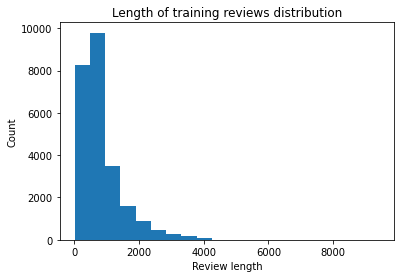

Number of unique words in training dataset: 75923
Max length of train review: 9425 
Avg length of train review: 845.16536 
Max length of test review: 8869 
Avg length of test review: 855.22736


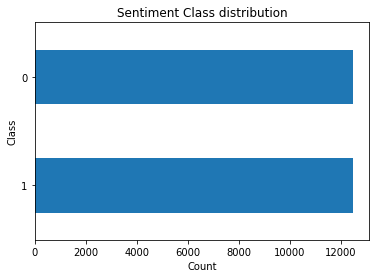

In [95]:
train_review_len = train_df['review'].str.len()
# Visualize length of reviews distribution
plt.hist(train_review_len, bins=20)
plt.xlabel('Review length')
plt.ylabel('Count')
plt.title('Length of training reviews distribution')
plt.show()

# Visualize class distribution in training dataset
ax = train_df['sentiment'].value_counts().plot(kind='barh')
ax.set_xlabel('Count')
ax.set_ylabel('Class')
ax.set_title('Sentiment Class distribution')

vectorizer = text.CountVectorizer()
X = vectorizer.fit_transform(train_df['review'])
words = vectorizer.get_feature_names_out()
print('Number of unique words in training dataset:', len(words))

train_len, test_len = train_review_len, test.str.len()
print('Max length of train review:', train_len.max(), '\nAvg length of train review:', train_len.mean(), \
      '\nMax length of test review:', test_len.max(), '\nAvg length of test review:', test_len.mean())

In [122]:
# Model configurations
MAX_LENGTH = 800
MAX_FEATURES = 2000
EMBED_OUTPUT_DIMS = 64
EPOCHS = 10
BATCH_SIZE = 32

### Tokenize and Vectorize training text 

In [123]:
vectorize_layer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_LENGTH
)

# Fit state of preprocessing layer to training dataset
train_text = train_df['review'].to_numpy()
vectorize_layer.adapt(train_text)

### Build LSTM model

In [124]:
np.random.seed(5)
model = Sequential()
model = Sequential(
    [
      vectorize_layer,  # encoder to convert text to sequence of token indices
      Embedding(input_dim=vectorize_layer.vocabulary_size(), output_dim=EMBED_OUTPUT_DIMS, input_length=MAX_LENGTH),
      Bidirectional(LSTM(64)),
      Dense(1, activation='sigmoid')
    ]
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_42 (Text  (None, 800)              0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 800, 64)           128000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 194,177
Trainable params: 194,177
Non-trainable params: 0
_________________________________________________________________


### Train model

In [125]:
callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_text, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[callback])

Epoch 1/10
625/625 [==============================] - 52s 78ms/step - loss: 0.5239 - accuracy: 0.7379 - val_loss: 0.5823 - val_accuracy: 0.6952
Epoch 2/10
625/625 [==============================] - 48s 77ms/step - loss: 0.3646 - accuracy: 0.8495 - val_loss: 0.3404 - val_accuracy: 0.8570
Epoch 3/10
625/625 [==============================] - 48s 77ms/step - loss: 0.3000 - accuracy: 0.8838 - val_loss: 0.3378 - val_accuracy: 0.8592
Epoch 4/10
625/625 [==============================] - 48s 77ms/step - loss: 0.2940 - accuracy: 0.8864 - val_loss: 0.3425 - val_accuracy: 0.8568
Epoch 5/10
625/625 [==============================] - 48s 76ms/step - loss: 0.2709 - accuracy: 0.8948 - val_loss: 0.4117 - val_accuracy: 0.8282


782/782 [==============================] - 24s 31ms/step - loss: 0.2794 - accuracy: 0.8934
Training loss: 0.2793751060962677, Training accuracy: 0.8934000134468079


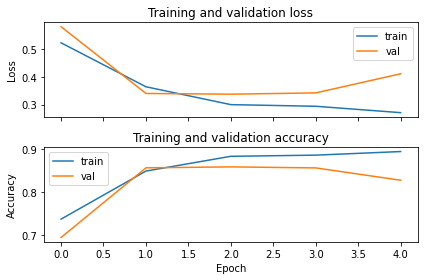

In [126]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Evaluate model's performance with best weights from training
train_score = model.evaluate(train_text, train_labels)
print(f'Training loss: {train_score[0]}, Training accuracy: {train_score[1]}')

fig, axs = plt.subplots(2, 1)
# Plot loss
axs[0].plot(loss, label='train')
axs[0].plot(val_loss, label='val')
axs[0].set(ylabel='Loss')
axs[0].set_title('Training and validation loss')
# Plot accuracy
axs[1].plot(acc, label='train')
axs[1].plot(val_acc, label='val')
axs[1].set(ylabel='Accuracy')
axs[1].set_title('Training and validation accuracy')
plt.xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

### Make predictions & process output

In [127]:
pred = model.predict(test)

for i in range(len(pred)):
  if pred[i][0] > 0.5:
    pred[i][0] = 1
  else: pred[i][0] = 0

test_pred = pred.flatten().astype('int')
# Decode 0 labels to -1
test_pred = np.where(test_pred == 0, -1, 1)

In [128]:
print(test_pred)
len(test_pred[test_pred == 1]), len(test_pred[test_pred == -1])

[-1 -1 -1 ...  1  1 -1]


(13556, 11444)

### Save test data predictions to text file

In [129]:
def output_data(data):
    with open('test.txt', 'w') as txtfile:
        for d in data:
          if d == 1:
            txtfile.write(f'+{d}' + '\n')
          else:
            txtfile.write(str(d) + '\n')
            
output_data(test_pred)